## Stage 2: Traditional statistical and machine learning methods

At this stage we will address the genre prediction problem with traditional statistical or machine learning methods.

The notebook includes:

- Detailed description and implementation of different models
- Description of performance metrics
- Careful performance evaluations for  models
- Visualizations of the metrics for performance evaluation
- Discussion of the differences between the models, their strengths, weaknesses, etc. 
- Discussion of the performances we achieved, and how we might be able to improve them in the future


### <span style="color:#08088A">  Needed libraries  </span>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import imdb
import numpy                  as np
import pandas                 as pd
import scipy                  as sp
import sklearn.neighbors      as knn
import matplotlib
import matplotlib.pyplot      as plt
import seaborn
import requests
import urllib
import joblib
import requests
import json
import os
import random
import seaborn as sns
#import statsmodels.api as sm
from ast                                  import literal_eval
from matplotlib                           import rcParams
from sklearn                              import discriminant_analysis
from sklearn.decomposition                import PCA
from sklearn                              import preprocessing
from sklearn.linear_model                 import LogisticRegression as LogReg
from sklearn.discriminant_analysis        import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis        import QuadraticDiscriminantAnalysis as QDA
from scipy.stats                          import mode
from sklearn                              import linear_model
from IPython.core.interactiveshell        import InteractiveShell
from time                                 import sleep
from collections                          import Counter
from itertools                            import combinations, permutations
from urlparse                             import urljoin


In [3]:
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [4]:
matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = (20, 10)
rcParams['axes.facecolor'] = "w"
rcParams['grid.color'] = "gray"
rcParams['grid.linewidth'] = 0.5

### <span style="color:#08088A">  Description of our data:  </span> 
 
Our data is a merged database through IMDB IDs using TMDB and IMDB sources. The TMDB data includes metadata such as popularity, production company, production country, average vote score.  TMDb also provides the movie posters in addition to the metadata. You can find below description of variables below: 
 
**TMDB Data Description**
 
Adult: A logical value that indicates if a movie is only for adult people (TRUE) or not (FALSE). backdrop_path: The backdrop of the movie. 
belong_to_collection: The collections to which the movie belongs. 
Budget: The budget for the movie.
Genres: The movie’s genre. 
Homepage: The movie’s homepage.
Id: The movie ID.
imdb_id: The movie imdb ID. 
original_language: The original language of the movie. 
original_title: The original title of the movie. 
Overview: A brief plot. 
Popularity: An index of the movie’s popularity.
poster_path: The poster of the movie. 
production_companies: The producer companies.
production_countries: The countries involved in the production. 
release_data: The date of the release. 
Revenue: The movie’s income.
Runtime: The length of the movie. 
spoken_language: The language spoken in the movie. 
Status: The movie’s status. 
Tagline: The movie’s tagline. 
Title: The movie’s title. 
Video: The videos associated to the movie. 
vote_average: The average of the votes.
vote_count: The number of votes.                    
 
**IMDB Data Description**
 
director: Person list; a list of director's name (e.g.: ['Brian De Palma'])
cast: Person list; list of actor/actress, with the currentRole instance
                   variable set to a Character object which describe his
                   role/duty.
writer: Person list; list of writers ['Oscar Fraley (novel)']
rating: string; user rating on IMDb from 1 to 10 (e.g. '7.8')
votes: string; number of votes (e.g. '24,101')
runtimes: string list; in minutes ['119'] or something like ['USA:118',
          'UK:116']
genres: string list; one or more in (Action, Adventure, Adult, Animation,
                                         Comedy, Crime, Documentary, Drama, Family, Fantasy, Film-Noir,
                                         Horror, Musical, Mystery, Romance, Sci-Fi, Short, Thriller,
                                         War, Western) and other genres defined by IMDb.
akas: string list; list of aka for this movie
certificates: string list; ['UK:15', 'USA:R']
mpaa: string; the mpaa rating
  
### <span style="color:#08088A">  Features chosen for X:  </span> 
 
Our database is a combination of metadata, poster images, plot summary word vectors,

**Metadata:**Our correlation analysis shows that even though some metadata features will be useful in our prediction such as production company, production country and voting average, overall there is weak correlation with genre. Therefore our prediction accuracy would be low if we only use metadata from TMDB and IMDB.  In addition to the metadata that have correlation over 3% with genre, we will incorporate Image recognition of posters and natural language processing of plot summaries / actors, writer and directors to help us improve our accuracy. 

**Actors/directors/writers:** can also be useful in predicting genre, common sense tells us that some actors regularly act in comedies, some act in dramas etc. We can also treat each actor/writer/director as a feature. 

**Plot summaries:** Our aim is to analyse plot summaries by turning each plot into a vector of features. We will tokenize and count the word occurrences using a bag of words approach. Individual token occurrence frequency (normalized or not) will be treated as a feature, as features will then enable us to predict the genre. 

**Posters:**  We will convert each poster into pixels and use PCA to reduce dimensionality in the next milestone. Top PC scores that represent 90% of the variance will be used.

###  <span style="color:#08088A">  Loading the imdb and tmdb merge data:  </span> 

In [5]:
merged_mdb_final = pd.read_csv('merged_mdb_final.txt')
merged_mdb_final = merged_mdb_final.drop('Unnamed: 0', axis=1)

In [6]:
merged_mdb_final.head(2)

,title_x,imdb_id,id,overview,budget,genres,release_date,revenue,runtime,original_language,...,vote_count,status,adult,title_y,rating,votes,year,cast,director,writer
0,[u'Notorious'],38787,303,"[u'Released shortly after the war, this classi...",2000000,"[{u'id': 53, u'name': u'Thriller'}, {u'id': 18...",8/15/1946,24464742,102.0,en,...,250,Released,0,[u'Notorious'],8.0,76704.0,1946.0,"[u'Cary Grant', u'Ingrid Bergman', u'Claude Ra...",[u'Alfred Hitchcock'],"[u'Ben Hecht', u'John Taintor Foote', u'Alfred..."
1,[u'The ABCs of Death'],1935896,87436,"[u""An ambitious anthology film featuring segme...",0,"[{u'id': 27, u'name': u'Horror'}]",6/28/2013,21660,123.0,en,...,137,Released,0,[u'The ABCs of Death'],4.7,14951.0,2012.0,"[u'Eva Llorach', u'Miquel Insua', u'Alejandra ...","[u'Kaare Andrews', u'Angela Bettis', u'H\xe9l\...","[u'Ant Timpson', u'Nacho Vigalondo', u'Adri\xe..."


In [7]:
merged_mdb_final.columns

Index([u'title_x', u'imdb_id', u'id', u'overview', u'budget', u'genres',
       u'release_date', u'revenue', u'runtime', u'original_language',
       u'popularity', u'original_title', u'poster_path',
       u'production_companies', u'production_countries', u'spoken_languages',
       u'tagline', u'vote_average', u'vote_count', u'status', u'adult',
       u'title_y', u'rating', u'votes', u'year', u'cast', u'director',
       u'writer'],
      dtype='object')

###  <span style="color:#08088A">  Poster data:  </span> 

In [8]:
-

###  <span style="color:#08088A">  Clean data:  </span> 


We need to clean the data before making any analysis as there are dictionaries inside the dataframe and multiple labels under one column such as in genres, production country and production company. 



In [9]:
# convert dictionaries to list
merged_mdb_final['genres'] = merged_mdb_final['genres'].apply(lambda x:[genre['name'] for genre in literal_eval(x)])
merged_mdb_final['production_companies'] = merged_mdb_final['production_companies'].apply(lambda x:[prod['name'] for prod in literal_eval(x)])
merged_mdb_final['production_countries'] = merged_mdb_final['production_countries'].apply(lambda x:[prod_count['name'] for prod_count in literal_eval(x)])
merged_mdb_final['spoken_languages'] = merged_mdb_final['spoken_languages'].apply(lambda x:[spoken['name'] for spoken in literal_eval(x)])

In [10]:
merged_mdb_final['genres'][0:10]

0              [Thriller, Drama, Romance]
1                                [Horror]
2                               [Western]
3             [Adventure, Drama, Romance]
4                                [Comedy]
5               [Action, Science Fiction]
6                [Thriller, Crime, Drama]
7                           [Documentary]
8                [Comedy, Drama, Romance]
9    [Comedy, Animation, Family, Fantasy]
Name: genres, dtype: object

In [6]:
#Convert "cast" dictionary into list seperated by comma

#This takes a couple of minutes, please revise if there is algorithmically a more efficient way
for i in range(len(merged_mdb_final['cast'])):
    merged_mdb_final['cast'][i] = str(merged_mdb_final['cast'][i]).split(',')
    
#Keep only main actor as predictor variable since there are many actors and 
#keeping actors with minor parts do not seem make a lot of sense
for i in range(len(merged_mdb_final['cast'])):
    merged_mdb_final['cast'][i] = merged_mdb_final['cast'][i][0]

    

/home/emre/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/emre/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
#Keep the main production company and country
#This takes a couple of minutes, please revise if there is algorithmically a more efficient way
for i in range(len(merged_mdb_final['production_companies'])):
    if(len(merged_mdb_final['production_companies'][i])>0):
        merged_mdb_final['production_companies'][i] = merged_mdb_final['production_companies'][i][0]
 
for i in range(len(merged_mdb_final['production_countries'])):
    if(len(merged_mdb_final['production_countries'][i])>0):
        merged_mdb_final['production_countries'][i] = merged_mdb_final['production_countries'][i][0]

In [13]:
merged_mdb_final['modified_genres'] = merged_mdb_final['genres']


In [14]:
#Delete features that will not be of interest for modelling

merged_mdb_final = merged_mdb_final.drop(['spoken_languages'], axis=1)
merged_mdb_final = merged_mdb_final.drop(['release_date'], axis=1)
merged_mdb_final = merged_mdb_final.drop(['title_y'], axis=1)
#merged_mdb_final = merged_mdb_final.drop(['imdb_id'], axis=1)
#merged_mdb_final = merged_mdb_final.drop(['original_title'], axis=1)
merged_mdb_final = merged_mdb_final.drop(['tagline'], axis=1)
merged_mdb_final = merged_mdb_final.drop(['status'], axis=1)
merged_mdb_final = merged_mdb_final.drop(['id'], axis=1)
merged_mdb_final = merged_mdb_final.drop(['adult'], axis=1)


In [15]:
#Convert categorical variables with strings to numerical values prior to correlation analysis/modelling
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(merged_mdb_final['director'])
merged_mdb_final['director'] = le.transform(merged_mdb_final['director']) 

le.fit(merged_mdb_final['writer'])
merged_mdb_final['writer'] = le.transform(merged_mdb_final['writer']) 

le.fit(merged_mdb_final['cast'])
merged_mdb_final['cast'] = le.transform(merged_mdb_final['cast']) 

le.fit(merged_mdb_final['production_countries'])
merged_mdb_final['production_countries'] = le.transform(merged_mdb_final['production_countries']) 

le.fit(merged_mdb_final['production_companies'])
merged_mdb_final['production_companies'] = le.transform(merged_mdb_final['production_companies']) 



LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

In [16]:
merged_mdb_final.head(5)

,title_x,imdb_id,overview,budget,genres,revenue,runtime,original_language,popularity,original_title,...,production_countries,vote_average,vote_count,rating,votes,year,cast,director,writer,modified_genres
0,[u'Notorious'],38787,"[u'Released shortly after the war, this classi...",2000000,"[Thriller, Drama, Romance]",24464742,102.0,en,1.520523,[u'Notorious'],...,63,7.7,250,8.0,76704.0,1946.0,400,90,378,"[Thriller, Drama, Romance]"
1,[u'The ABCs of Death'],1935896,"[u""An ambitious anthology film featuring segme...",0,[Horror],21660,123.0,en,1.227384,[u'The ABCs of Death'],...,63,4.7,137,4.7,14951.0,2012.0,792,1493,278,[Horror]
2,"[u'Duck, You Sucker']",67140,[u'At the beginning of the 1913 Mexican Revolu...,0,[Western],0,157.0,en,0.335946,[u'Gi\xf9 la testa'],...,32,7.6,129,7.7,22832.0,1971.0,2114,2489,3508,[Western]
3,[u'The Sheltering Sky'],100594,"[u'An American couple (John Malkovich, Debra W...",25000000,"[Adventure, Drama, Romance]",2075084,138.0,en,0.341105,[u'The Sheltering Sky'],...,32,6.3,37,6.8,9117.0,1990.0,636,253,2946,"[Adventure, Drama, Romance]"
4,[u'Recep \u0130vedik 3'],1577061,[u'No overview found.'],0,[Comedy],0,95.0,en,0.358557,[u'Recep \u0130vedik 3'],...,60,5.4,12,4.1,12993.0,2010.0,2172,2698,3509,[Comedy]


### Creating Y variables - Dealing with multi labels

It seems that choosing genre data in TMDB and IMDB is a complicated process as some movies have multiple genres associated. In order for our model to train and predict from one genre per each observation, we duplicated movie data for each genre. So if a movie has two genres, we will have an observation for each genre. 

In [17]:
merged_mdb_final['pairs_genre'] = merged_mdb_final.modified_genres.map(lambda x : list(combinations(x, 2)))
merged_mdb_final['uni_genre'] = merged_mdb_final.modified_genres.map(lambda x : list(combinations(x, 1)))

In [18]:
melted_uni_genre = pd.DataFrame(pd.concat([pd.Series(row['imdb_id'], row['uni_genre']) for x, 
                                           row in merged_mdb_final.iterrows()])).reset_index()

In [19]:
melted_uni_genre.columns = ['uni_genre', 'imdb_id']

In [20]:
melted_pairs_genre = pd.DataFrame(pd.concat([pd.Series(row['imdb_id'], row['pairs_genre']) for x, 
                                             row in merged_mdb_final.iterrows()])).reset_index()

In [21]:
melted_pairs_genre.columns = ['pairs_genre', 'imdb_id']

In [22]:
melted_pairs_genre.head()

,pairs_genre,imdb_id
0,"(Thriller, Drama)",38787
1,"(Thriller, Romance)",38787
2,"(Drama, Romance)",38787
3,"(Adventure, Drama)",100594
4,"(Adventure, Romance)",100594


In [23]:
melted_uni_genre.head()

,uni_genre,imdb_id
0,"(Thriller,)",38787
1,"(Drama,)",38787
2,"(Romance,)",38787
3,"(Horror,)",1935896
4,"(Western,)",67140


In [24]:
Counter(melted_uni_genre.uni_genre)

Counter({(u'Action',): 1007,
         (u'Adventure',): 632,
         (u'Animation',): 286,
         (u'Comedy',): 1459,
         (u'Crime',): 577,
         (u'Documentary',): 151,
         (u'Drama',): 1969,
         (u'Family',): 507,
         (u'Fantasy',): 374,
         (u'Foreign',): 36,
         (u'History',): 139,
         (u'Horror',): 620,
         (u'Music',): 133,
         (u'Mystery',): 349,
         (u'Romance',): 731,
         (u'Science Fiction',): 481,
         (u'TV Movie',): 78,
         (u'Thriller',): 1207,
         (u'War',): 132,
         (u'Western',): 98})

In [25]:
merged_mdb_uni = pd.merge(melted_uni_genre, merged_mdb_final , how ='left', on = 'imdb_id');

In [26]:
print len(merged_mdb_uni), 
#merged_mdb_uni.head(2)

10966


In [27]:
merged_mdb_pair = pd.merge(melted_pairs_genre, merged_mdb_final , how ='left', on = 'imdb_id');

In [28]:
print len(merged_mdb_pair), 
#merged_mdb_pair.tail(5)

11043


In [29]:
merged_mdb_uni.shape, merged_mdb_pair.shape

((10966, 25), (11043, 25))

In [30]:
merged_mdb_uni.iloc[:,15:25].head(10)

,vote_count,rating,votes,year,cast,director,writer,modified_genres,pairs_genre,uni_genre_y
0,250,8.0,76704.0,1946.0,400,90,378,"[Thriller, Drama, Romance]","[(Thriller, Drama), (Thriller, Romance), (Dram...","[(Thriller,), (Drama,), (Romance,)]"
1,250,8.0,76704.0,1946.0,400,90,378,"[Thriller, Drama, Romance]","[(Thriller, Drama), (Thriller, Romance), (Dram...","[(Thriller,), (Drama,), (Romance,)]"
2,250,8.0,76704.0,1946.0,400,90,378,"[Thriller, Drama, Romance]","[(Thriller, Drama), (Thriller, Romance), (Dram...","[(Thriller,), (Drama,), (Romance,)]"
3,137,4.7,14951.0,2012.0,792,1493,278,[Horror],[],"[(Horror,)]"
4,129,7.7,22832.0,1971.0,2114,2489,3508,[Western],[],"[(Western,)]"
5,37,6.8,9117.0,1990.0,636,253,2946,"[Adventure, Drama, Romance]","[(Adventure, Drama), (Adventure, Romance), (Dr...","[(Adventure,), (Drama,), (Romance,)]"
6,37,6.8,9117.0,1990.0,636,253,2946,"[Adventure, Drama, Romance]","[(Adventure, Drama), (Adventure, Romance), (Dr...","[(Adventure,), (Drama,), (Romance,)]"
7,37,6.8,9117.0,1990.0,636,253,2946,"[Adventure, Drama, Romance]","[(Adventure, Drama), (Adventure, Romance), (Dr...","[(Adventure,), (Drama,), (Romance,)]"
8,12,4.1,12993.0,2010.0,2172,2698,3509,[Comedy],[],"[(Comedy,)]"
9,72,5.5,5820.0,2013.0,1673,1021,1750,"[Action, Science Fiction]","[(Action, Science Fiction)]","[(Action,), (Science Fiction,)]"


In [31]:
merged_mdb_uni.keys()

Index([u'uni_genre_x', u'imdb_id', u'title_x', u'overview', u'budget',
       u'genres', u'revenue', u'runtime', u'original_language', u'popularity',
       u'original_title', u'poster_path', u'production_companies',
       u'production_countries', u'vote_average', u'vote_count', u'rating',
       u'votes', u'year', u'cast', u'director', u'writer', u'modified_genres',
       u'pairs_genre', u'uni_genre_y'],
      dtype='object')

### Prepare data for modeling - Uni

In [32]:
#Uni
#Delete features that will not be of interest

merged_mdb_uni = merged_mdb_uni.drop(['imdb_id'], axis=1)
merged_mdb_uni = merged_mdb_uni.drop(['title_x'], axis=1)
merged_mdb_uni = merged_mdb_uni.drop(['original_language'], axis=1)
merged_mdb_uni = merged_mdb_uni.drop(['poster_path'], axis=1)
merged_mdb_uni = merged_mdb_uni.drop(['modified_genres'], axis=1)
merged_mdb_uni = merged_mdb_uni.drop(['uni_genre_y'], axis=1)


In [33]:
merged_mdb_uni.head(5)

,uni_genre_x,overview,budget,genres,revenue,runtime,popularity,original_title,production_companies,production_countries,vote_average,vote_count,rating,votes,year,cast,director,writer,pairs_genre
0,"(Thriller,)","[u'Released shortly after the war, this classi...",2000000,"[Thriller, Drama, Romance]",24464742,102.0,1.520523,[u'Notorious'],1149,63,7.7,250,8.0,76704.0,1946.0,400,90,378,"[(Thriller, Drama), (Thriller, Romance), (Dram..."
1,"(Drama,)","[u'Released shortly after the war, this classi...",2000000,"[Thriller, Drama, Romance]",24464742,102.0,1.520523,[u'Notorious'],1149,63,7.7,250,8.0,76704.0,1946.0,400,90,378,"[(Thriller, Drama), (Thriller, Romance), (Dram..."
2,"(Romance,)","[u'Released shortly after the war, this classi...",2000000,"[Thriller, Drama, Romance]",24464742,102.0,1.520523,[u'Notorious'],1149,63,7.7,250,8.0,76704.0,1946.0,400,90,378,"[(Thriller, Drama), (Thriller, Romance), (Dram..."
3,"(Horror,)","[u""An ambitious anthology film featuring segme...",0,[Horror],21660,123.0,1.227384,[u'The ABCs of Death'],879,63,4.7,137,4.7,14951.0,2012.0,792,1493,278,[]
4,"(Western,)",[u'At the beginning of the 1913 Mexican Revolu...,0,[Western],0,157.0,0.335946,[u'Gi\xf9 la testa'],1155,32,7.6,129,7.7,22832.0,1971.0,2114,2489,3508,[]


In [34]:
#Uni
#Fix missing values
merged_mdb_uni['runtime'].fillna(value=merged_mdb_uni['runtime'].mean(), inplace=True)
merged_mdb_uni['rating'].fillna(value=merged_mdb_uni['rating'].mean(), inplace=True)
merged_mdb_uni['votes'].fillna(value=merged_mdb_uni['votes'].mean(), inplace=True)
merged_mdb_uni['year'].fillna(value=merged_mdb_uni['year'].mean(), inplace=True)

#budget
mean_plug = merged_mdb_uni[merged_mdb_uni['budget']>0]['budget'].mean()

for i in range(merged_mdb_uni.shape[0]):
    if(merged_mdb_uni['budget'][i]==0):
        merged_mdb_uni['budget'][i] = mean_plug
        
#revenue
mean_plug = merged_mdb_uni[merged_mdb_uni['revenue']>0]['revenue'].mean()

for i in range(merged_mdb_uni.shape[0]):
    if(merged_mdb_uni['revenue'][i]==0):
        merged_mdb_uni['revenue'][i] = mean_plug
        


In [36]:
#Encode
merged_mdb_uni2 = merged_mdb_uni

#Convert Y variable to numerical value prior to modelling
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(merged_mdb_uni2['uni_genre_x'])
merged_mdb_uni2['uni_genre_x'] = le.transform(merged_mdb_uni2['uni_genre_x']) 


LabelEncoder()

In [37]:
merged_mdb_uni2.describe()

,uni_genre_x,budget,revenue,runtime,popularity,production_companies,production_countries,vote_average,vote_count,rating,votes,year,cast,director,writer
count,10966.000000,1.096600e+04,1.096600e+04,10966.000000,10966.000000,10966.000000,10966.000000,10966.000000,10966.000000,10966.000000,1.096600e+04,10966.000000,10966.000000,10966.000000,10966.000000
mean,7.762174,3.352025e+07,1.020663e+08,101.036395,0.839532,823.529911,51.744939,5.852380,272.291993,6.247605,4.382379e+04,1997.501922,1303.374065,1462.325278,2018.665603
std,5.692114,2.763338e+07,1.206148e+08,30.019058,1.101293,530.606707,20.458051,1.322162,648.064524,1.148413,9.252998e+04,18.309320,749.197277,834.866792,1188.878368
min,0.000000,1.000000e+00,1.000000e+00,0.000000,0.149949,0.000000,0.000000,0.000000,0.000000,1.400000,6.000000e+00,1903.000000,0.000000,0.000000,0.000000
25%,3.000000,2.100000e+07,5.516344e+07,90.000000,0.258154,301.000000,54.000000,5.300000,20.000000,5.600000,3.152000e+03,1991.000000,649.000000,738.000000,983.000000
50%,6.000000,3.352025e+07,1.020662e+08,98.000000,0.493629,924.000000,63.000000,6.000000,65.000000,6.300000,1.207600e+04,2004.000000,1264.000000,1450.000000,2005.500000
75%,13.000000,3.352025e+07,1.020662e+08,111.000000,0.984264,1346.000000,63.000000,6.600000,223.000000,7.100000,4.268200e+04,2010.000000,1969.000000,2228.000000,3049.750000
max,19.000000,2.800000e+08,2.781506e+09,705.000000,18.775748,1598.000000,64.000000,10.000000,9573.000000,9.500000,1.437777e+06,2017.000000,2607.000000,2856.000000,4067.000000


###  <span style="color:#08088A">  NATURAL LANGUAGE PROCESSING OF PLOT SUMMARIES:  </span> 

Our aim is to analyse plot summaries and title by turning them into a vector of features. We will tokenize and count the word occurrences using a bag of words approach. Individual token occurrence frequency will be treated as a feature, as features will then enable us to predict the genre.


In [39]:
merged_mdb_final['overview'].fillna(value=np.nan, inplace=True)
print(merged_mdb_final['overview'])

from sklearn.feature_extraction.text import CountVectorizer

#Overview
vectorizer = CountVectorizer(stop_words='english',decode_error='ignore',analyzer='word', min_df=4)

corpus = merged_mdb_uni2['overview'].values.astype('U')

wordvec = vectorizer.fit_transform(corpus.ravel())
wordvec = wordvec.toarray()
words = vectorizer.get_feature_names()
print("number of words in plot summary: ", len(words))
overview_db = pd.DataFrame(wordvec,columns=words)

#original_title
vectorizer = CountVectorizer(stop_words='english',decode_error='ignore',analyzer='word', min_df=4)

corpus = merged_mdb_uni2['original_title'].values.astype('U')

wordvec = vectorizer.fit_transform(corpus.ravel())
wordvec = wordvec.toarray()
words = vectorizer.get_feature_names()
print("number of words in title: ", len(words))
original_title_db = pd.DataFrame(wordvec,columns=words)



0       [u'Released shortly after the war, this classi...
1       [u"An ambitious anthology film featuring segme...
2       [u'At the beginning of the 1913 Mexican Revolu...
3       [u'An American couple (John Malkovich, Debra W...
4                                 [u'No overview found.']
5       [u'It\u2019s been 20 years since the corporati...
6       [u'Two brothers, on either side of the law, fa...
7       [u'A purely observational non-fiction film tha...
8       [u'A conservative lawyer named Diane takes her...
9       [u'When Brainy Smurf is favored to win the ann...
10      [u"A woman's lifelong pursuit of lost family d...
11      [u'The young Harold lives in his own world of ...
12      [u'P-A-X-497/341, aka \u201cPax\u201d , a curi...
13      [u'Jacq Vaucan, an insurance agent of ROC robo...
14      [u'Andrew returns to his hometown for the fune...
15      [u'A police detective is in charge of the inve...
16      [u'"The Straight Story" chronicles a trip made...
17      [u'Beg

### PCA for overview (plot summary) and title

In [40]:
from sklearn.decomposition import PCA

#Overview

#Number of vectors for d=3
d=100

#Fit PCA model
pca = PCA(n_components = d)
pca.fit(overview_db)
pc = pca.components_
overview_db_reduced = pca.transform(overview_db)

pca.explained_variance_ratio_.sum()

PCA(copy=True, n_components=100, whiten=False)

0.23678980938924304

In [41]:
#original_title

#Number of vectors for d=3
d=50

#Fit PCA model
pca2 = PCA(n_components = d)
pca2.fit(original_title_db)
pc = pca2.components_
original_title_db_reduced = pca2.transform(original_title_db)

pca2.explained_variance_ratio_.sum()

PCA(copy=True, n_components=50, whiten=False)

0.20397150260829702

In [42]:
overview_db_reduced = pd.DataFrame(overview_db_reduced)
original_title_db_reduced = pd.DataFrame(original_title_db_reduced)

In [43]:
original_title_db_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.015592,-0.005735,0.009263,-0.014544,0.006591,-0.000804,0.012360,-0.008121,0.006992,0.004225,...,0.004452,0.000702,-0.002160,0.005036,-0.00070,-0.001071,-0.000178,-0.000277,-0.000030,-0.002688
1,0.015592,-0.005735,0.009263,-0.014544,0.006591,-0.000804,0.012360,-0.008121,0.006992,0.004225,...,0.004452,0.000702,-0.002160,0.005036,-0.00070,-0.001071,-0.000178,-0.000277,-0.000030,-0.002688
2,0.015592,-0.005735,0.009263,-0.014544,0.006591,-0.000804,0.012360,-0.008121,0.006992,0.004225,...,0.004452,0.000702,-0.002160,0.005036,-0.00070,-0.001071,-0.000178,-0.000277,-0.000030,-0.002688
3,0.035988,-0.285933,-0.436720,0.031043,-0.747430,0.231126,0.111129,-0.069579,-0.054692,0.001789,...,0.004660,0.001860,-0.005338,-0.006118,0.00736,-0.017016,0.002119,-0.022768,-0.001568,0.000091
4,0.020906,-0.010149,0.016812,-0.023863,0.012373,-0.003024,0.019902,-0.023912,0.007056,0.015236,...,-0.048110,-0.008537,0.003974,-0.026873,0.00935,0.029271,0.016595,0.026793,-0.004626,0.028715


### Merge Overview - Title PCA and metadata database

In [44]:
merged_mdb_uni3 = merged_mdb_uni2

In [45]:
# Merge 
merged_mdb_uni3 = merged_mdb_uni3.drop(['genres'], axis=1)
merged_mdb_uni3 = merged_mdb_uni3.drop(['pairs_genre'], axis=1)
merged_mdb_uni3 = merged_mdb_uni3.drop(['overview'], axis=1)
merged_mdb_uni3 = merged_mdb_uni3.drop(['original_title'], axis=1)
merged_mdb_uni3 = pd.concat([merged_mdb_uni3, overview_db_reduced], axis=1)
merged_mdb_uni3 = pd.concat([merged_mdb_uni3, original_title_db_reduced], axis=1)
merged_mdb_uni3.head()

,uni_genre_x,budget,genres,revenue,runtime,popularity,production_companies,production_countries,vote_average,vote_count,...,40,41,42,43,44,45,46,47,48,49
0,17,2000000,"[Thriller, Drama, Romance]",24464742,102.0,1.520523,1149,63,7.7,250,...,0.004452,0.000702,-0.002160,0.005036,-0.00070,-0.001071,-0.000178,-0.000277,-0.000030,-0.002688
1,6,2000000,"[Thriller, Drama, Romance]",24464742,102.0,1.520523,1149,63,7.7,250,...,0.004452,0.000702,-0.002160,0.005036,-0.00070,-0.001071,-0.000178,-0.000277,-0.000030,-0.002688
2,14,2000000,"[Thriller, Drama, Romance]",24464742,102.0,1.520523,1149,63,7.7,250,...,0.004452,0.000702,-0.002160,0.005036,-0.00070,-0.001071,-0.000178,-0.000277,-0.000030,-0.002688
3,11,33520253,[Horror],21660,123.0,1.227384,879,63,4.7,137,...,0.004660,0.001860,-0.005338,-0.006118,0.00736,-0.017016,0.002119,-0.022768,-0.001568,0.000091
4,19,33520253,[Western],102066250,157.0,0.335946,1155,32,7.6,129,...,-0.048110,-0.008537,0.003974,-0.026873,0.00935,0.029271,0.016595,0.026793,-0.004626,0.028715


In [125]:
merged_mdb_uni3.columns

Index([         u'uni_genre_x',               u'budget',
                    u'revenue',              u'runtime',
                 u'popularity', u'production_companies',
       u'production_countries',         u'vote_average',
                 u'vote_count',               u'rating',
       ...
                            40,                      41,
                            42,                      43,
                            44,                      45,
                            46,                      47,
                            48,                      49],
      dtype='object', length=165)

In [124]:
#Data ready for modeling
dataset = merged_mdb_uni3
dataset = dataset.dropna(axis = 0)

### Change data types

In [126]:
dataset['production_companies'] = dataset['production_companies'].astype('category')
dataset['production_countries'] = dataset['production_countries'].astype('category')
dataset['cast'] = dataset['cast'].astype('category')
dataset['director'] = dataset['director'].astype('category')
dataset['writer'] = dataset['writer'].astype('category')
dataset['uni_genre_x'] = dataset['uni_genre_x'].astype('category')

# Basic Modeling

We have used Naive Model, logistic regression, random forest and SVM to classify genre. 

In [127]:
dataset['uni_genre_x'].value_counts()

6     1969
3     1459
17    1207
0     1007
14     731
1      632
11     620
4      577
7      507
15     481
8      374
13     349
2      286
5      151
10     139
12     133
18     132
19      98
16      78
9       36
Name: uni_genre_x, dtype: int64

**Imbalanced Y:**
It seems that some genres are much more frequent than others, for example out of a sample of about 6500 movies, Western genre is observed 19 times while Drama is observed 1200 times. This makes accurate prediction difficult as the data is imbalanced. Therefore we will incorporate balancing weights to our model.

In [128]:
#from sklearn.model_selection port train_test_split
#dataset_train, dataset_test  = train_test_split(dataset, test_size=0.2, random_state=42)

from sklearn.cross_validation import train_test_split as sk_split

# Split final version of data into training/test data sets
dataset_train, dataset_test = sk_split(dataset, test_size = 0.3)

#We'll use this for training, including cross validation
#Set dependent variables and predictors
y_train = dataset_train['uni_genre_x']
y_test = dataset_test['uni_genre_x']
x_train = dataset_train.drop(['uni_genre_x'], axis=1)
x_test = dataset_test.drop(['uni_genre_x'], axis=1)

### Naive Model:

In [129]:
float(dataset.iloc[:,0].value_counts().max())/dataset.iloc[:,0].value_counts().sum()

0.179554988145176

### Logistic Regression

In [133]:
#Logistic Regression without balanced class weights
from sklearn import linear_model
import sklearn as sk

logit = sk.linear_model.LogisticRegression( C = 1000)
logit.fit(x_train, y_train)
logit.score(x_train, y_train)
logit.score(x_test, y_test)

#predict Y and frequency table
pred_y = logit.predict(x_test) 

def unique_count(a):
    unique, inverse = np.unique(a, return_inverse=True)
    count = np.zeros(len(unique), np.int)
    np.add.at(count, inverse, 1)
    return np.vstack(( unique, count)).T

print unique_count(pred_y)


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

0.17926003126628454

0.18115501519756838

[[   1  275]
 [   2    2]
 [   3   21]
 [   4    4]
 [   6 2985]
 [   8    3]]


In [134]:
#Logistic Regression with balanced weights

logit = sk.linear_model.LogisticRegression( C = 1000, class_weight='balanced')
logit.fit(x_train, y_train)
logit.score(x_train, y_train)
logit.score(x_test, y_test)

#predict Y
pred_y = logit.predict(x_test) 
print unique_count(pred_y)

LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.065528921313183955

0.056231003039513679

[[  0 318]
 [  1 567]
 [  2  56]
 [  5   5]
 [  6 349]
 [  7 593]
 [  8 131]
 [  9 464]
 [ 10 101]
 [ 12   1]
 [ 15 185]
 [ 16 305]
 [ 18  67]
 [ 19 148]]


In [140]:
c = [0.00001,  1, 1000, 1000000]

train_acc = []
test_acc = []

for i in c:
    logit = sk.linear_model.LogisticRegression( C = i, class_weight='balanced')
    logit.fit(x_train, y_train)
    train_acc.append(logit.score(x_train, y_train))
    test_acc.append(logit.score(x_test, y_test))


LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1000000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

([<matplotlib.axis.XTick at 0x7f606bb17390>,
 <a list of 4 Text xticklabel objects>)

(0, 1.1)

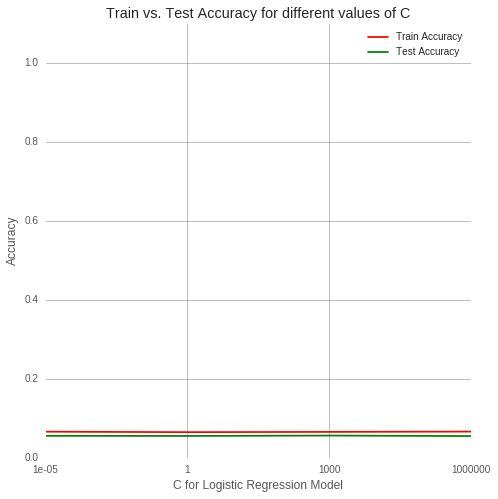

In [141]:

#Visualize accuracy for different C
plt.figure(figsize=(7,7))
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(test_acc, color='g', label='Test Accuracy')
plt.xticks(range(4), c)
plt.xlabel('C for Logistic Regression Model')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.title('Train vs. Test Accuracy for different values of C')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

It seems optimizing C does not seem to make much difference in test set accuracy of the model

In [135]:
#SVM without balanced weights
clf = svm.SVC(kernel="rbf", gamma=1, C=1)
clf.fit(x_train, y_train) 
clf.score(x_train, y_train)
clf.score(x_test, y_test)

pred_y = clf.predict(x_test) 
print unique_count(pred_y)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

0.51524231370505469

0.051367781155015196

[[   0  306]
 [   1  161]
 [   2   29]
 [   3  422]
 [   4   57]
 [   5   10]
 [   6 1317]
 [   7  106]
 [   8   47]
 [   9    5]
 [  10   33]
 [  11  107]
 [  12   29]
 [  13   36]
 [  14  178]
 [  15   45]
 [  16    6]
 [  17  374]
 [  18   11]
 [  19   11]]


In [97]:
#SVM with balanced weights
from sklearn import svm

clf = svm.SVC(kernel="rbf", class_weight='balanced',gamma=1, C=1)
clf.fit(x_train, y_train) 
clf.score(x_train, y_train)
clf.score(x_test, y_test)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

0.51472120896300155

0.047112462006079027

SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=0.3, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

([<matplotlib.axis.XTick at 0x7f606b57d0d0>,
 <a list of 7 Text xticklabel objects>)

(0, 1.1)

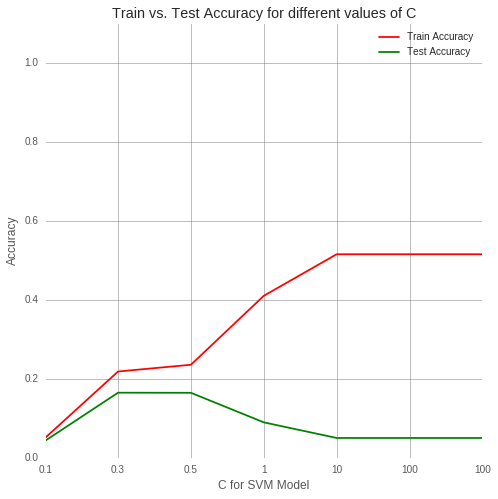

In [105]:
#Optimize C in SVM model
c = [0.1, 0.3, 0.5, 1, 10, 100]

train_acc = []
test_acc = []

for i in c:
    SVMmodel = svm.SVC(C=i, class_weight='balanced',gamma=1, kernel='rbf')
    SVMmodel.fit(x_train, y_train)
    train_acc.append(SVMmodel.score(x_train, y_train))
    test_acc.append(SVMmodel.score(x_test, y_test))

#Visualize accuracy for different C
plt.figure(figsize=(7,7))
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(test_acc, color='g', label='Test Accuracy')
plt.xticks(range(7), c)
plt.xlabel('C for SVM Model')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.title('Train vs. Test Accuracy for different values of C')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.3, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=100, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

([<matplotlib.axis.XTick at 0x7f606b5eac90>,
 <a list of 7 Text xticklabel objects>)

(0, 1.1)

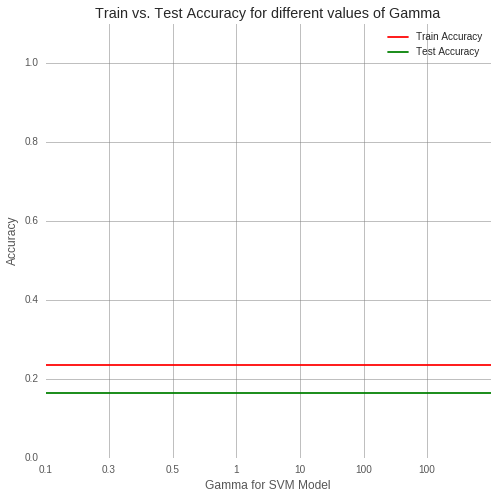

In [107]:
#Optimize gamma in SVM model
gamma = [0.001,0.01,0.1, 0.3, 0.5, 1, 10, 100]

train_acc = []
test_acc = []

for i in gamma:
    SVMmodel = svm.SVC(C=0.5, class_weight='balanced',gamma=i, kernel='rbf')
    SVMmodel.fit(x_train, y_train)
    train_acc.append(SVMmodel.score(x_train, y_train))
    test_acc.append(SVMmodel.score(x_test, y_test))

#Visualize accuracy for different C
plt.figure(figsize=(7,7))
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(test_acc, color='g', label='Test Accuracy')
plt.xticks(range(7), c)
plt.xlabel('Gamma for SVM Model')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.title('Train vs. Test Accuracy for different values of Gamma')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [108]:
#Use optimized C value for SVM model as Gamma does not seem to change
clf = svm.SVC(kernel="rbf", class_weight='balanced',gamma=1, C=0.5)
clf.fit(x_train, y_train) 
clf.score(x_train, y_train)
clf.score(x_test, y_test)

SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

0.23540906722251173

0.16443768996960487

In [115]:
pred_y = clf.predict(x_test) 
print unique_count(pred_y)


[[   2   97]
 [   5   10]
 [   6 2960]
 [   9   13]
 [  10   54]
 [  12   43]
 [  16   43]
 [  18   37]
 [  19   33]]


In [136]:
from sklearn.ensemble import RandomForestClassifier

boundries = 30
max_features = ['sqrt',None]
n_estimators = range(boundries)
max_depth = range(boundries)

score_rf = np.zeros((boundries,boundries))
k = max_features[1]

i = 20
j = 5
m = 7

dt_rf = RandomForestClassifier(min_samples_leaf = m ,max_depth  = j+1 , max_features = k, n_estimators = i+1, random_state=99)
dt_rf.fit(x_train,y_train)
score_rf[i,j] = dt_rf.score(x_train,y_train)

dt_rf.score(x_train,y_train)
dt_rf.score(x_test,y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=1,
            oob_score=False, random_state=99, verbose=0, warm_start=False)

0.29116727462219905

0.20243161094224923

In [137]:
pred_y = dt_rf.predict(x_test) 
print unique_count(pred_y)

[[   0  195]
 [   1   63]
 [   2  114]
 [   3  569]
 [   5   11]
 [   6 1890]
 [   7   61]
 [   8    2]
 [  11   76]
 [  14    4]
 [  15   15]
 [  17  290]]


In [139]:
#Fit Random Forest model with balanced weights
dt_rf = RandomForestClassifier(min_samples_leaf = m ,max_depth  = j+1 ,class_weight='balanced', max_features = k, n_estimators = i+1, random_state=99)
dt_rf.fit(x_train,y_train)
score_rf[i,j] = dt_rf.score(x_train,y_train)

dt_rf.score(x_train,y_train)
dt_rf.score(x_test,y_test)

pred_y = dt_rf.predict(x_test) 
print unique_count(pred_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=6, max_features=None,
            max_leaf_nodes=None, min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=1,
            oob_score=False, random_state=99, verbose=0, warm_start=False)

0.15489838457529964

0.092097264437689966

[[  0  21]
 [  1  23]
 [  2 303]
 [  3 490]
 [  4 255]
 [  5 123]
 [  6  11]
 [  7  33]
 [  8  82]
 [  9  92]
 [ 10 403]
 [ 11 322]
 [ 12 118]
 [ 13  50]
 [ 14  71]
 [ 15 203]
 [ 16 149]
 [ 17 139]
 [ 18 114]
 [ 19 288]]


## <span style="color:#08088A">  Performance Summary of Models:  </span> 

**Naive Model:**
With naive model where we assign genre with the most observed one, we get 18% accuracy. Therefore our aim is to beat that benchmark. 

**Logistic Regression:**
If we do not use balanced weights, we are able to achieve about 18% test set accuracy but the model only predicts among 6 genres.
When we introduce balanced weights, the model predicts among 14 genres but accuracy drops to 5%. Optimizing C does not seem to help. 

**SVM Model:**
With SVM model we are able to achieve 5% test set accuracy. The balanced/unbalanced class weights do not make a difference with SVM Model. 
It seems that with optimized hyperparameters we can achieve 16% training set accuracy with SVM model but it predicts among 9 genres.

**Random Forest Model:**
With unbalanced class weights RF model achieves 20% test set accuracy and it predicts among 12 genres.
With balanced weights, RF model achieves only 9% test set accuracy and it predicts from all the genres. 

## <span style="color:#08088A">Conclusion </span> 
Using traditional machine learning algorithms with the predictor variables (metadata and Overview and title with PCA) we seem to perform better than a Naive model only with Random Forest model with unbalanced class weights. 

**Barriers for high accuracy:**
1. Some genre has low number of observations so it is hard to learn from
2. Data is imbalanced and there are about 20 genres to predict
3. Using bag-of-words and dummy variables we get thousands of features, which is computationally hard to run and there is risk of overfitting. Therefore we used PCA to reduce dimensionality, but we lose a significant portion of the variance. 
4. We have duplicated observations for each genre which might be confusing the model and we might actually be predicting correctly among the multi labels but we are only testing accuracy for the associated single label. 
5. There are no good predictors of genre in the metadata as our previous correlation analysis showed.

**This milestone presented a good learning opportunity for us and get more familiar with the data. 
Going forward our aim will be to improve our model through:**

1. Apply deep learning
2. Don't use PCA to reduce the dimension of bag-of-words and consider temporal modeling to capture the context in the overview text, such as hidden markov model, conditional random field or RNN. 
3. Use poster image data
4. Don't reduce multi-label problem to single-label problem. Use a single label each time and combine the final prediction using one-vs-all. 
